In [46]:
# Librerías estándar
import re

# Librerías de análisis y utilidades
import pandas as pd
import nltk
from nltk.corpus import stopwords
import spacy

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Configuración de spaCy
import spacy.cli
spacy.cli.download("pt_core_news_sm")


✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [47]:
import pt_core_news_sm          # Importa el modelo pequeño de spaCy para procesar texto en portugués

spc_pt = pt_core_news_sm.load() # Carga el modelo en memoria para poder usarlo (tokenizar, lematizar, etc.)


In [48]:
data = pd.read_csv("../data/raw/olist_order_reviews_dataset.csv")  # Carga el archivo CSV
data.head(15)                                                      # Muestra las primeras 15 filas para inspeccionar los datos


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,NaN,NaN,2017-07-16 00:00:00,2017-07-18 19:30:34
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,NaN,NaN,2018-08-14 00:00:00,2018-08-14 21:36:06
8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,NaN,NaN,2017-05-17 00:00:00,2017-05-18 12:05:37
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47


In [49]:
# Elimina columnas irrelevantes del DataFrame directamente sobre el original
data.drop(['order_id', 'review_creation_date', 'review_answer_timestamp'], axis=1, inplace=True)


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               99224 non-null  object
 1   review_score            99224 non-null  int64 
 2   review_comment_title    11568 non-null  object
 3   review_comment_message  40977 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.0+ MB


In [51]:
# Calcula el porcentaje de filas con review_id duplicado
duplicados = round(sum(data.duplicated("review_id"))/len(data)*100, 2)
print(f"Reviews con id duplicado: {duplicados}%")

Reviews con id duplicado: 0.82%


In [52]:
# Filtra todas las filas que tienen review_id duplicado
data[data.duplicated("review_id", keep = False)].sort_values(by = "review_id")

,review_id,review_score,review_comment_title,review_comment_message
46678,00130cbe1f9d422698c812ed8ded1919,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid..."
29841,00130cbe1f9d422698c812ed8ded1919,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid..."
90677,0115633a9c298b6a98bcbe4eee75345f,5,NaN,NaN
63193,0115633a9c298b6a98bcbe4eee75345f,5,NaN,NaN
92876,0174caf0ee5964646040cd94e15ac95e,1,NaN,Produto entregue dentro de embalagem do fornec...
...,...,...,...,...
31120,fe5c833752953fed3209646f1f63b53c,1,NaN,"Comprei dois produtos e ambos, mesmo enviados ..."
7870,ff2fc9e68f8aabfbe18d710b83aabd30,2,NaN,NaN
82521,ff2fc9e68f8aabfbe18d710b83aabd30,2,NaN,NaN
73951,ffb8cff872a625632ac983eb1f88843c,3,NaN,NaN


In [ ]:
# Elimina las filas duplicadas basándose en review_id
data.drop_duplicates("review_id", inplace = True)

In [ ]:
# Reemplaza todos los valores nulos en el DataFrame por cadenas vacías
data.fillna('', inplace = True)

In [ ]:
# Crea una nueva columna combinando el título y el mensaje de la reseña en un solo texto
data['review'] = data['review_comment_title'] + ' ' + data['review_comment_message']

In [ ]:
# Filtra y conserva solo las filas donde la reseña no está vacía
data = data[data['review'] != ' ']

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42389 entries, 3 to 99223
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               42389 non-null  object
 1   review_score            42389 non-null  int64 
 2   review_comment_title    42389 non-null  object
 3   review_comment_message  42389 non-null  object
 4   review                  42389 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


In [15]:
data.head()

,review_id,review_score,review_comment_title,review_comment_message,review
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...
9,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...
12,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok..."


In [ ]:
# Cuenta cuántas reseñas hay por cada puntaje y devuelve la distribución
data['review_score'].value_counts()

review_score
5    21672
1     8723
4     6241
3     3615
2     2138
Name: count, dtype: int64

In [ ]:
# Convierte los puntajes de reseña en etiquetas binarias, marcando como 1 las reseñas positivas y 0 las negativas o neutras.
labels = []

for score in data['review_score']:
    if score > 3:
        labels.append(1)
    else:
        labels.append(0)

data['label'] = labels

In [18]:
data.head(10)

,review_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,1
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...,1
9,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...,1
12,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.\r\n",1
15,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok...",1
16,9314d6f9799f5bfba510cc7bcd468c01,2,,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...","GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI ...",0
19,373cbeecea8286a2b66c97b1b157ec46,1,Não chegou meu produto,Péssimo,Não chegou meu produto Péssimo,0
22,d21bbc789670eab777d27372ab9094cc,5,Ótimo,Loja nota 10,Ótimo Loja nota 10,1
24,0e0190b9db53b689b285d3f3916f8441,5,,obrigado pela atençao amim dispensada,obrigado pela atençao amim dispensada,1
27,fe3db7c069d694bab50cc43463f91608,5,,A compra foi realizada facilmente.\r\nA entreg...,A compra foi realizada facilmente.\r\nA entre...,1


In [ ]:
# Descarga el conjunto de stopwords de NLTK para poder usarlas en el preprocesamiento de texto
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Carga la lista de palabras vacías (stopwords) en portugués para filtrar palabras irrelevantes del texto
stopwords_pt = stopwords.words("portuguese")

In [ ]:
# Muestra la lista de stopwords en portugués que se usarán para limpiar el texto
stopwords_pt

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

In [ ]:
# Elimina 'não' y 'nem' de la lista de stopwords para que estas palabras negativas importantes se conserven en el análisis
stopwords_pt.remove('não')
stopwords_pt.remove('nem')

In [ ]:
# Función que limpia y normaliza texto en portugués: 
# convierte a minúsculas, elimina caracteres no alfabéticos, filtra stopwords y aplica lematización usando spaCy.
def limpiar_texto(texto):
    texto = texto.lower()

    texto = re.sub(r"[\W\d_]+", " ", texto) # Elimina caracteres no alfabéticos, dígitos y guiones bajos

    texto = [pal for pal in texto.split() if pal not in stopwords_pt] # Quita stopwords

    spc_texto = spc_pt(" ".join(texto))
    tokens = [word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in spc_texto]

    return " ".join(tokens)

In [ ]:
# Aplica la función de limpieza a cada reseña, normalizando el texto en la columna 'review'
data['review'] = data['review'].apply(limpiar_texto)


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42389 entries, 3 to 99223
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               42389 non-null  object
 1   review_score            42389 non-null  int64 
 2   review_comment_title    42389 non-null  object
 3   review_comment_message  42389 non-null  object
 4   review                  42389 non-null  object
 5   label                   42389 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.3+ MB


In [26]:
data.head(10)

,review_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,recebi bem antes prazo estipular,1
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,parabéns loja lannister adorar comprar Interne...,1
9,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendar aparelho eficiente site marca apare...,1
12,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",pouco travar valor ta bom,1
15,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",super recomendo vendedor confiável produto ok ...,1
16,9314d6f9799f5bfba510cc7bcd468c01,2,,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",gostar saber sempre recebi compra agora decpci...,0
19,373cbeecea8286a2b66c97b1b157ec46,1,Não chegou meu produto,Péssimo,não chegar produto péssimo,0
22,d21bbc789670eab777d27372ab9094cc,5,Ótimo,Loja nota 10,bom loja noto,1
24,0e0190b9db53b689b285d3f3916f8441,5,,obrigado pela atençao amim dispensada,obrigar atençao amim dispensar,1
27,fe3db7c069d694bab50cc43463f91608,5,,A compra foi realizada facilmente.\r\nA entreg...,compra realizar facilmente entregar efetuar an...,1


In [ ]:
# Filtra las filas donde, después de la limpieza, la reseña quedó vacía
data[data['review'] == '']

,review_id,review_score,review_comment_title,review_comment_message,review,label
297,2b4a570df87cd63b232272dd9dcac0cf,5,,A,,1
463,3140a4eb146655fe104d54d385f9e9a0,5,,10,,1
583,3814f35a6ebd64d27e2130f30ec05255,4,5,,,1
598,057c9a1e8e767d8bf6fa59ac43a82435,4,4,,,1
939,8f965d010b3119d9962e091de3425fb9,4,,*******************,,1
...,...,...,...,...,...,...
94778,014f70270fa59804f14eb3df2ca690d2,5,,........................,,1
96770,47850e2adbd18f61f2af4af9b7656198,5,,👍🏻👌🏻👏🏻,,1
97441,e47fd0401fce7a7b6283da2a5a8ba563,5,10,,,1
98032,f004d8b3a2ff22e3c030285842cf629a,5,*****,,,1


In [ ]:
# Elimina las filas donde la reseña quedó vacía tras la limpieza
data = data[data['review'] != '']

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42129 entries, 3 to 99223
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               42129 non-null  object
 1   review_score            42129 non-null  int64 
 2   review_comment_title    42129 non-null  object
 3   review_comment_message  42129 non-null  object
 4   review                  42129 non-null  object
 5   label                   42129 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.2+ MB


In [ ]:
# Exporta el DataFrame procesado a un CSV con solo las columnas necesarias
data.to_csv('../data/processed/olist_preprocesado.csv', index= False, columns= ['review_id', 'review', 'label'])


In [ ]:
# Crea un vectorizador Bag-of-Words con codificación binaria y un máximo de 5000 características
vectorizer = CountVectorizer(binary=True, max_features=5000)

texto = data['review']  # Selecciona la columna de texto procesado

X_bow = vectorizer.fit_transform(texto)  # Ajusta el vectorizador y transforma el texto en una matriz de características


In [ ]:
# Convierte la matriz dispersa generada por Bag-of-Words en un arreglo denso
X_bow.toarray()


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(42129, 5000))

In [ ]:
# Muestra la forma de la matriz Bag-of-Words y el tipo de estructura que devuelve
print(X_bow.shape, type(X_bow))


(42129, 5000) <class 'scipy.sparse._csr.csr_matrix'>


In [ ]:
# Crea un vectorizador TF-IDF con un máximo de 5000 características
tfidf_vect = TfidfVectorizer(max_features=5000)

# Ajusta el vectorizador y transforma el texto en una matriz TF-IDF
X_tfidf = tfidf_vect.fit_transform(texto)


In [ ]:
# Muestra la matriz TF-IDF en su formato disperso, indicando filas, columnas y valores almacenados
print(X_tfidf)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 286560 stored elements and shape (42129, 5000)>
  Coords	Values
  (0, 3887)	0.3791024185243098
  (0, 530)	0.4216662787174378
  (0, 302)	0.34731359832784564
  (0, 3525)	0.3007123525754108
  (0, 1677)	0.6836843212234234
  (1, 3202)	0.4892414742594241
  (1, 2560)	0.19882397928440354
  (1, 2448)	0.23170363263908653
  (1, 91)	0.24785614829751448
  (1, 929)	0.21821850298543743
  (1, 2361)	0.3523104488609883
  (1, 4285)	0.3501226235665138
  (1, 3714)	0.3716524669958482
  (1, 4604)	0.2396304257524001
  (1, 1816)	0.34075863213371443
  (2, 3935)	0.11490327709108057
  (2, 319)	0.6523449676350572
  (2, 1449)	0.20839956145395863
  (2, 4366)	0.15140562933240995
  (2, 2696)	0.4424419185839537
  (2, 2245)	0.3051083577025364
  (2, 800)	0.09458202994246223
  (2, 3146)	0.14583855168601553
  (2, 3006)	0.2362340240138591
  (2, 439)	0.2517483837856711
  :	:
  (42126, 143)	0.19082659928616444
  (42126, 2636)	0.21881084259958994
  (42126, 3425)	0.1

In [ ]:
# Divide los datos Bag-of-Words en conjuntos de entrenamiento y prueba
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X_bow, data['label'], test_size=0.3, random_state=10
)

# Divide los datos TF-IDF en conjuntos de entrenamiento y prueba con la misma configuración
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X_tfidf, data['label'], test_size=0.3, random_state=10
)


In [ ]:
# Función que imprime métricas de desempeño y muestra la matriz de confusión:
# calcula accuracy, AUROC, F1 ponderado y visualiza la matriz con un mapa de calor.
def mostrar_metricas(y_true, y_pred):

    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("\nAUROC:", roc_auc_score(y_true, y_pred))
    print("\nF1-Score:", f1_score(y_true, y_pred, average='weighted'))
    print("\nMatriz de confusion:")
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
    plt.show()

In [ ]:
# Crea un modelo de Regresión Logística y lo entrena usando las características Bag-of-Words
reglog = LogisticRegression()

reglog.fit(X1_train, y1_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [40]:
y1_reglog_pred = reglog.predict(X1_test)

Acuracy:  0.8922383099928792

AUROC: 0.8760594456250318

F1-Score: 0.8917071228307876

Matriz de confusion:


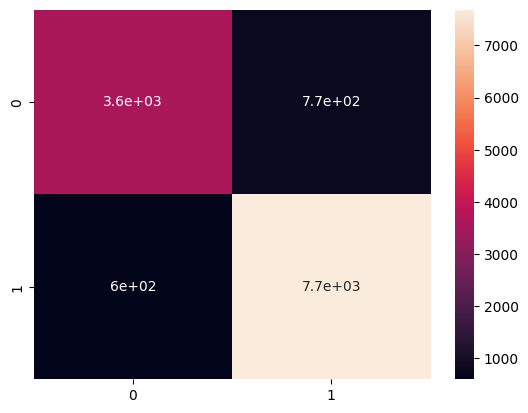

In [41]:
mostrar_metricas(y1_test, y1_reglog_pred)

Acuracy:  0.8880449402642614

AUROC: 0.8794404377880758

F1-Score: 0.8884052930349728

Matriz de confusion:


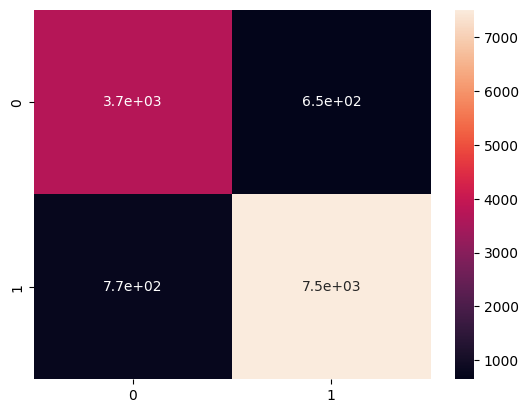

In [42]:
rf1 = RandomForestClassifier()
rf1.fit(X1_train, y1_train)
y1_dt_pred = rf1.predict(X1_test)
mostrar_metricas(y1_test, y1_dt_pred)